Data Source: https://www.kaggle.com/datasets/erdemtaha/cancer-data

In [1]:
# Data Preparation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

# Modelling
np.random.seed(42)
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv("data/Cancer_Data.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

The dataset is a 569x33 table. The 33 columns comprise of id (tumor id), diagnosis (classification label), 30 characteristics of the tumor, and an "Unnamed" column that is entirely null. The id and Unnamed columns will be dropped to result in a 569x30 table. All features are floating values and thus do not need to be made numerical. No other datapoints need to be dropped or filled - data is fully preprocessed.

In [4]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [5]:
# New definition of df
df = df.drop(columns = ["id", "Unnamed: 32"])
df["diagnosis"] = df["diagnosis"].replace({"M": 1, "B": 0})

df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Further analysis

In [6]:
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


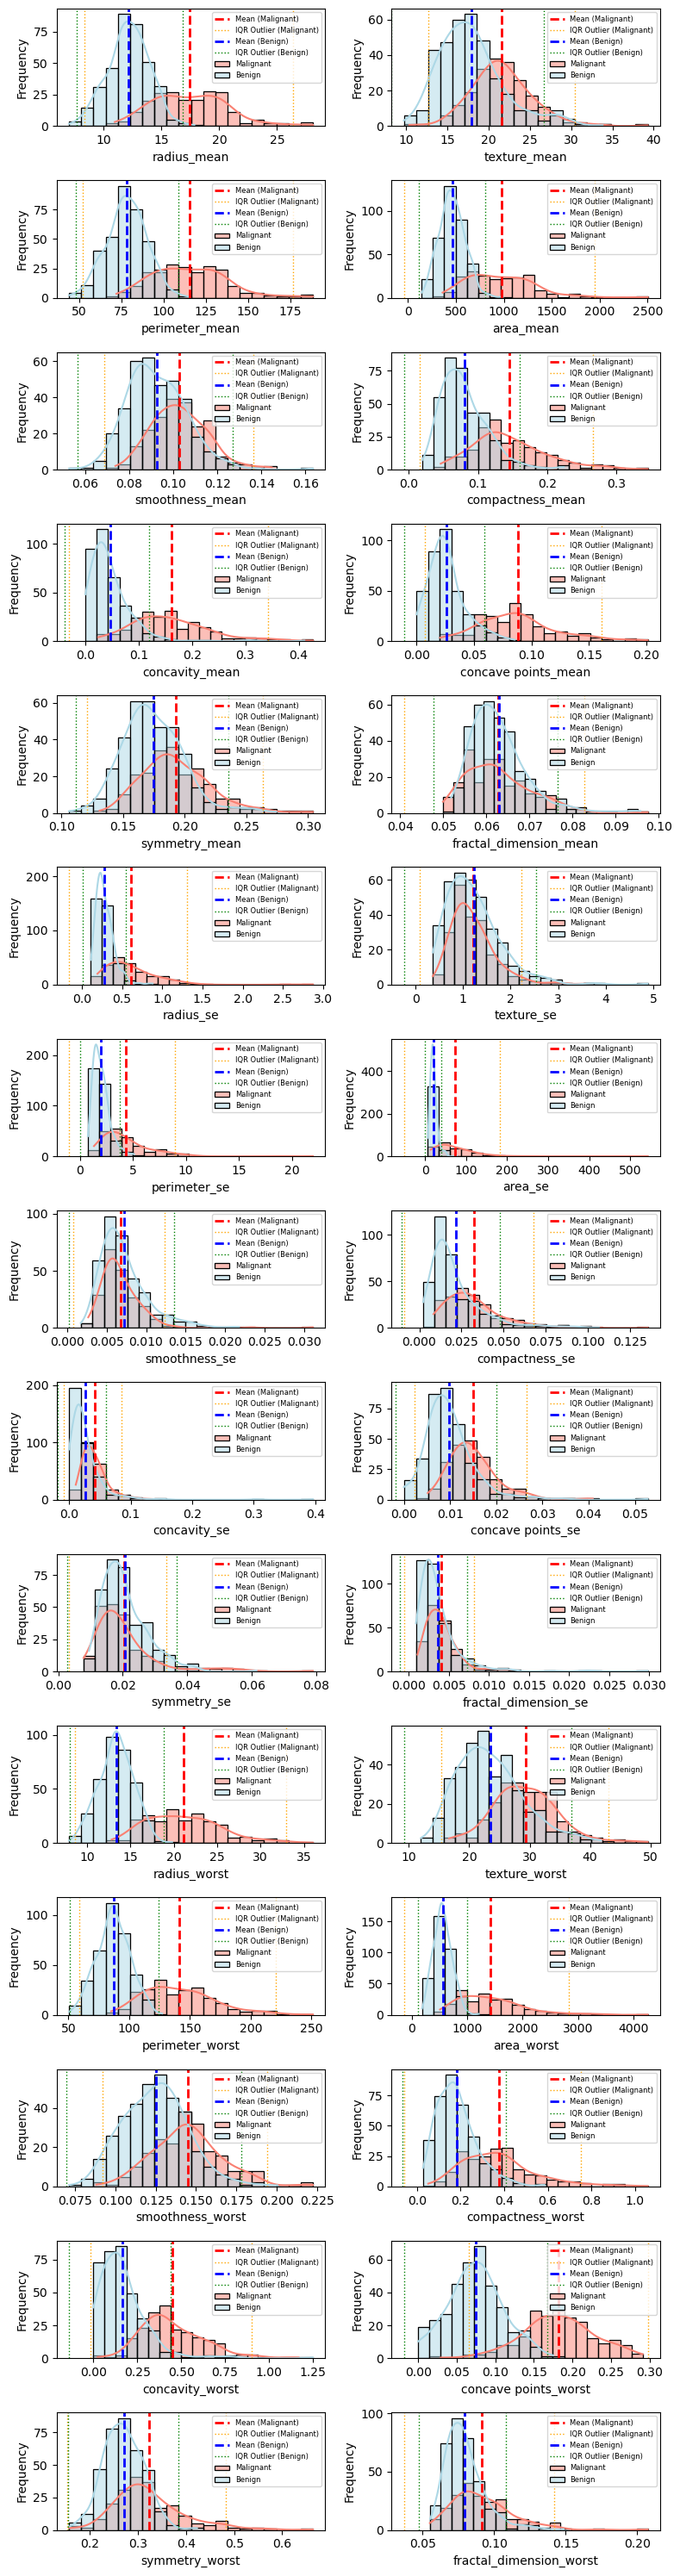

In [7]:
# Enumerate through columns and create a histogram for each

# Create subplots
fig, ax = plt.subplots(ncols=2, nrows=15, figsize=(8,30), dpi=100)
ax = ax.flatten()

# Plot histograms with Gaussian curve for each column (excluding "diagnosis")
for i, col in enumerate(df.drop(columns="diagnosis").columns):
    # Define data arrays
    malignant_data = df[df["diagnosis"] == 1][col]
    benign_data = df[df["diagnosis"] == 0][col]
    
    # Calculate common bin edges for the current column
    combined_data = np.concatenate([malignant_data, benign_data])
    bin_edges = np.histogram_bin_edges(combined_data, bins=20)
    
    # Plot histograms
    sns.histplot(malignant_data, color="salmon", label='Malignant', kde=True, ax=ax[i], bins=bin_edges)
    sns.histplot(benign_data, color="lightblue", label='Benign', kde=True, ax=ax[i], bins=bin_edges)
    ax[i].set(xlabel=col, ylabel="Frequency")
    
    # Calculate mean and IQR outliers
    mean_malignant = malignant_data.mean()
    mean_benign = benign_data.mean()
    q1_malignant = malignant_data.quantile(0.25)
    q3_malignant = malignant_data.quantile(0.75)
    iqr_malignant = q3_malignant - q1_malignant
    lo_thres_malignant = q1_malignant - 1.5*iqr_malignant
    hi_thres_malignant = q3_malignant + 1.5*iqr_malignant   
    
    q1_benign = benign_data.quantile(0.25)
    q3_benign = benign_data.quantile(0.75)
    iqr_benign = q3_benign - q1_benign
    lo_thres_benign = q1_benign - 1.5*iqr_benign
    hi_thres_benign = q3_benign + 1.5*iqr_benign
    
    # Draw vertical lines for mean and IQR outliers
    ax[i].axvline(mean_malignant, color='red', linestyle='dashed', linewidth=2, label='Mean (Malignant)')
    ax[i].axvline(hi_thres_malignant, color='orange', linestyle='dotted', linewidth=1, label='IQR Outlier (Malignant)')
    ax[i].axvline(lo_thres_malignant, color='orange', linestyle='dotted', linewidth=1)
    
    ax[i].axvline(mean_benign, color='blue', linestyle='dashed', linewidth=2, label='Mean (Benign)')
    ax[i].axvline(hi_thres_benign, color='green', linestyle='dotted', linewidth=1, label='IQR Outlier (Benign)')
    ax[i].axvline(lo_thres_benign, color='green', linestyle='dotted', linewidth=1)

    # Legend
    ax[i].legend(fontsize=6)
    
plt.tight_layout()
plt.show()


Some characteristics such as concavity and worst radius appear to exhibit significant differences in distribution between malignant and benign tumors, whereas others such as fractal dimension and texture appear to be indistinguishable from one another. Outliers as defined by the IQR are present in the dataset; these will be kept for baseline but may need to be removed during model tuning. Statistically insignificant dataset and noncorrelative characteristics demonstrated by p-values of t-test and correlation coefficients also may need to be dropped from the dataset during model tuning.

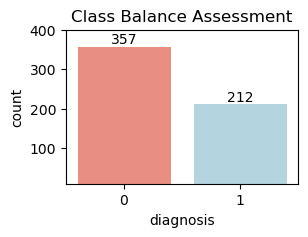

In [8]:
fig, ax = plt.subplots(figsize=(3, 2))
ax = sns.countplot(x="diagnosis", data=df, palette=["salmon","lightblue"])

for container in ax.containers:
    ax.bar_label(container)
    
ax.set(title="Class Balance Assessment", ylim=(10, 400))
plt.show()

In [9]:
minority_proportion = df[df["diagnosis"] == 1].count()[0]/len(df)
minority_proportion

0.37258347978910367

There is class imbalance with the benign tumor class making up only 37% of the entire dataset. During the model tuning process, the data may need to be resampled using SMOTE.

## Split Train and Test Data

In [10]:
# Re-run Section 1

from sklearn import preprocessing

# Define X and scale data to 0 mean
X = df.drop(columns = ["diagnosis"])

# Define y
y = df["diagnosis"]

# Split training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


y_train

68     0
181    1
63     0
248    0
60     0
      ..
71     0
106    0
270    0
435    1
102    0
Name: diagnosis, Length: 455, dtype: int64

In [11]:
X_train

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
68,9.029,17.33,58.79,250.5,0.10660,0.14130,0.31300,0.04375,0.2111,0.08046,...,10.310,22.65,65.50,324.7,0.14820,0.43650,1.25200,0.17500,0.4228,0.11750
181,21.090,26.57,142.70,1311.0,0.11410,0.28320,0.24870,0.14960,0.2395,0.07398,...,26.680,33.48,176.50,2089.0,0.14910,0.75840,0.67800,0.29030,0.4098,0.12840
63,9.173,13.86,59.20,260.9,0.07721,0.08751,0.05988,0.02180,0.2341,0.06963,...,10.010,19.23,65.59,310.1,0.09836,0.16780,0.13970,0.05087,0.3282,0.08490
248,10.650,25.22,68.01,347.0,0.09657,0.07234,0.02379,0.01615,0.1897,0.06329,...,12.250,35.19,77.98,455.7,0.14990,0.13980,0.11250,0.06136,0.3409,0.08147
60,10.170,14.88,64.55,311.9,0.11340,0.08061,0.01084,0.01290,0.2743,0.06960,...,11.020,17.45,69.86,368.6,0.12750,0.09866,0.02168,0.02579,0.3557,0.08020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,8.888,14.64,58.79,244.0,0.09783,0.15310,0.08606,0.02872,0.1902,0.08980,...,9.733,15.67,62.56,284.4,0.12070,0.24360,0.14340,0.04786,0.2254,0.10840
106,11.640,18.33,75.17,412.5,0.11420,0.10170,0.07070,0.03485,0.1801,0.06520,...,13.140,29.26,85.51,521.7,0.16880,0.26600,0.28730,0.12180,0.2806,0.09097
270,14.290,16.82,90.30,632.6,0.06429,0.02675,0.00725,0.00625,0.1508,0.05376,...,14.910,20.65,94.44,684.6,0.08567,0.05036,0.03866,0.03333,0.2458,0.06120
435,13.980,19.62,91.12,599.5,0.10600,0.11330,0.11260,0.06463,0.1669,0.06544,...,17.040,30.80,113.90,869.3,0.16130,0.35680,0.40690,0.18270,0.3179,0.10550


## Baseline selection of models

In [12]:
# <100K samples
# recommend LinearSVC, KNeighbors Classifer by Scikit Learn
# also try RandomForestClassifier, LogisticRegression

# note: tried LinearSVC. prompted to increase interations due to failed convergence. 
#                        from 1,000 to 1,000,000 still no convergence. suggests to scale data to 0 mean using StandardScaler()
#                        no errors after scaling to 0 mean.
# note: tried KNeighbors. error showed that KNN does not have a score method. typically used for unsupervised learning. 
#                         will try sklearn.metrics.accuracy_score. error showed that KNN does not have predict method. 
#                         deleted "KNN": NearestNeighbors() from model dict

# from sklearn.svm import LinearSVC
# from sklearn.neighbors import NearestNeighbors // DELETED
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression

In [13]:
models = {
    "LinearSVC": LinearSVC(),
    "RandomForest": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression()
}

def evaluate_models(X, y, models):
    scoring_metrics = ["accuracy", "precision", "recall", "f1"]

    results = pd.DataFrame(index=scoring_metrics)

    for model_name, model in models.items():
        model_results = []

        for scoring_metric in scoring_metrics:
            cross_val_score_mean = np.mean(cross_val_score(model, X, y, cv=5, scoring=scoring_metric))
            model_results.append(cross_val_score_mean)

        results[model_name] = model_results

    return results


# for name, model in models:
#     scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
#     mean_score = scores.mean()
#     std_score = scores.std()
#     print(f"{name} - Mean Accuracy: {mean_score:.4f} (Std: {std_score:.4f})")

In [14]:
results_df = evaluate_models(X_train, y_train, models)
print(results_df)

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\

           LinearSVC  RandomForest  LogisticRegression
accuracy    0.923077      0.956044            0.938462
precision   0.785438      0.946544            0.933690
recall      0.823529      0.935116            0.899822
f1          0.885522      0.939360            0.915858


C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

In [15]:
# Recommendations to scale data for LinearSVC and LogisticRegression

# Rerun Section 1

In [16]:
from sklearn import preprocessing

# Define X and scale data to 0 mean
scaler_X = preprocessing.StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

# Define y
y_train
y_train_df = pd.DataFrame(y_train, columns=["diagnosis"], index=X_train.index)

X_scaled_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
68,-1.440753,-0.435319,-1.362085,-1.139118,0.780573,0.718921,2.823135,-0.119150,1.092662,2.458173,...,-1.232861,-0.476309,-1.247920,-0.973968,0.722894,1.186732,4.672828,0.932012,2.097242,1.886450
181,1.974096,1.733026,2.091672,1.851973,1.319843,3.426275,2.013112,2.665032,2.127004,1.558396,...,2.173314,1.311279,2.081617,2.137405,0.761928,3.265601,1.928621,2.698947,1.891161,2.497838
63,-1.399982,-1.249622,-1.345209,-1.109785,-1.332645,-0.307355,-0.365558,-0.696502,1.930333,0.954379,...,-1.295284,-1.040811,-1.245220,-0.999715,-1.438693,-0.548564,-0.644911,-0.970239,0.597602,0.057894
248,-0.981797,1.416222,-0.982587,-0.866944,0.059390,-0.596788,-0.820203,-0.845115,0.313264,0.074041,...,-0.829197,1.593530,-0.873572,-0.742947,0.796624,-0.729392,-0.774950,-0.809483,0.798928,-0.134497
60,-1.117700,-1.010259,-1.125002,-0.965942,1.269511,-0.439002,-0.983341,-0.930600,3.394436,0.950213,...,-1.085129,-1.334616,-1.117138,-0.896549,-0.174876,-0.995079,-1.209146,-1.354582,1.033544,-0.205732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,-1.480675,-1.066580,-1.362085,-1.157451,0.149987,0.944057,-0.035754,-0.514485,0.331474,3.755073,...,-1.352920,-1.628421,-1.336108,-1.045037,-0.469795,-0.059039,-0.627221,-1.016366,-1.032028,1.376025
106,-0.701497,-0.200650,-0.687880,-0.682204,1.327033,-0.036619,-0.229252,-0.353247,-0.036372,0.339253,...,-0.644011,0.614731,-0.647704,-0.626555,1.616328,0.085623,0.060743,0.116740,-0.156974,0.398365
270,0.048802,-0.555001,-0.065125,-0.061423,-2.261627,-1.466613,-1.028567,-1.105515,-1.103492,-1.249242,...,-0.275720,-0.806427,-0.379841,-0.339278,-1.989065,-1.307006,-1.127968,-1.239034,-0.708639,-1.271455
435,-0.038969,0.102073,-0.031374,-0.154780,0.737432,0.184701,0.298585,0.430059,-0.517123,0.372579,...,0.167478,0.868921,0.203878,-0.013556,1.291049,0.672020,0.632532,1.050012,0.434322,1.213362


In [17]:
# X_train, y_train
# X_scaled_df, y_train_df

In [18]:
# Create a DataFrame for scaled X_train values

df_scaled = pd.concat([X_scaled_df, y_train_df], axis=1)
df_scaled

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
68,-1.440753,-0.435319,-1.362085,-1.139118,0.780573,0.718921,2.823135,-0.119150,1.092662,2.458173,...,-0.476309,-1.247920,-0.973968,0.722894,1.186732,4.672828,0.932012,2.097242,1.886450,0
181,1.974096,1.733026,2.091672,1.851973,1.319843,3.426275,2.013112,2.665032,2.127004,1.558396,...,1.311279,2.081617,2.137405,0.761928,3.265601,1.928621,2.698947,1.891161,2.497838,1
63,-1.399982,-1.249622,-1.345209,-1.109785,-1.332645,-0.307355,-0.365558,-0.696502,1.930333,0.954379,...,-1.040811,-1.245220,-0.999715,-1.438693,-0.548564,-0.644911,-0.970239,0.597602,0.057894,0
248,-0.981797,1.416222,-0.982587,-0.866944,0.059390,-0.596788,-0.820203,-0.845115,0.313264,0.074041,...,1.593530,-0.873572,-0.742947,0.796624,-0.729392,-0.774950,-0.809483,0.798928,-0.134497,0
60,-1.117700,-1.010259,-1.125002,-0.965942,1.269511,-0.439002,-0.983341,-0.930600,3.394436,0.950213,...,-1.334616,-1.117138,-0.896549,-0.174876,-0.995079,-1.209146,-1.354582,1.033544,-0.205732,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,-1.480675,-1.066580,-1.362085,-1.157451,0.149987,0.944057,-0.035754,-0.514485,0.331474,3.755073,...,-1.628421,-1.336108,-1.045037,-0.469795,-0.059039,-0.627221,-1.016366,-1.032028,1.376025,0
106,-0.701497,-0.200650,-0.687880,-0.682204,1.327033,-0.036619,-0.229252,-0.353247,-0.036372,0.339253,...,0.614731,-0.647704,-0.626555,1.616328,0.085623,0.060743,0.116740,-0.156974,0.398365,0
270,0.048802,-0.555001,-0.065125,-0.061423,-2.261627,-1.466613,-1.028567,-1.105515,-1.103492,-1.249242,...,-0.806427,-0.379841,-0.339278,-1.989065,-1.307006,-1.127968,-1.239034,-0.708639,-1.271455,0
435,-0.038969,0.102073,-0.031374,-0.154780,0.737432,0.184701,0.298585,0.430059,-0.517123,0.372579,...,0.868921,0.203878,-0.013556,1.291049,0.672020,0.632532,1.050012,0.434322,1.213362,1


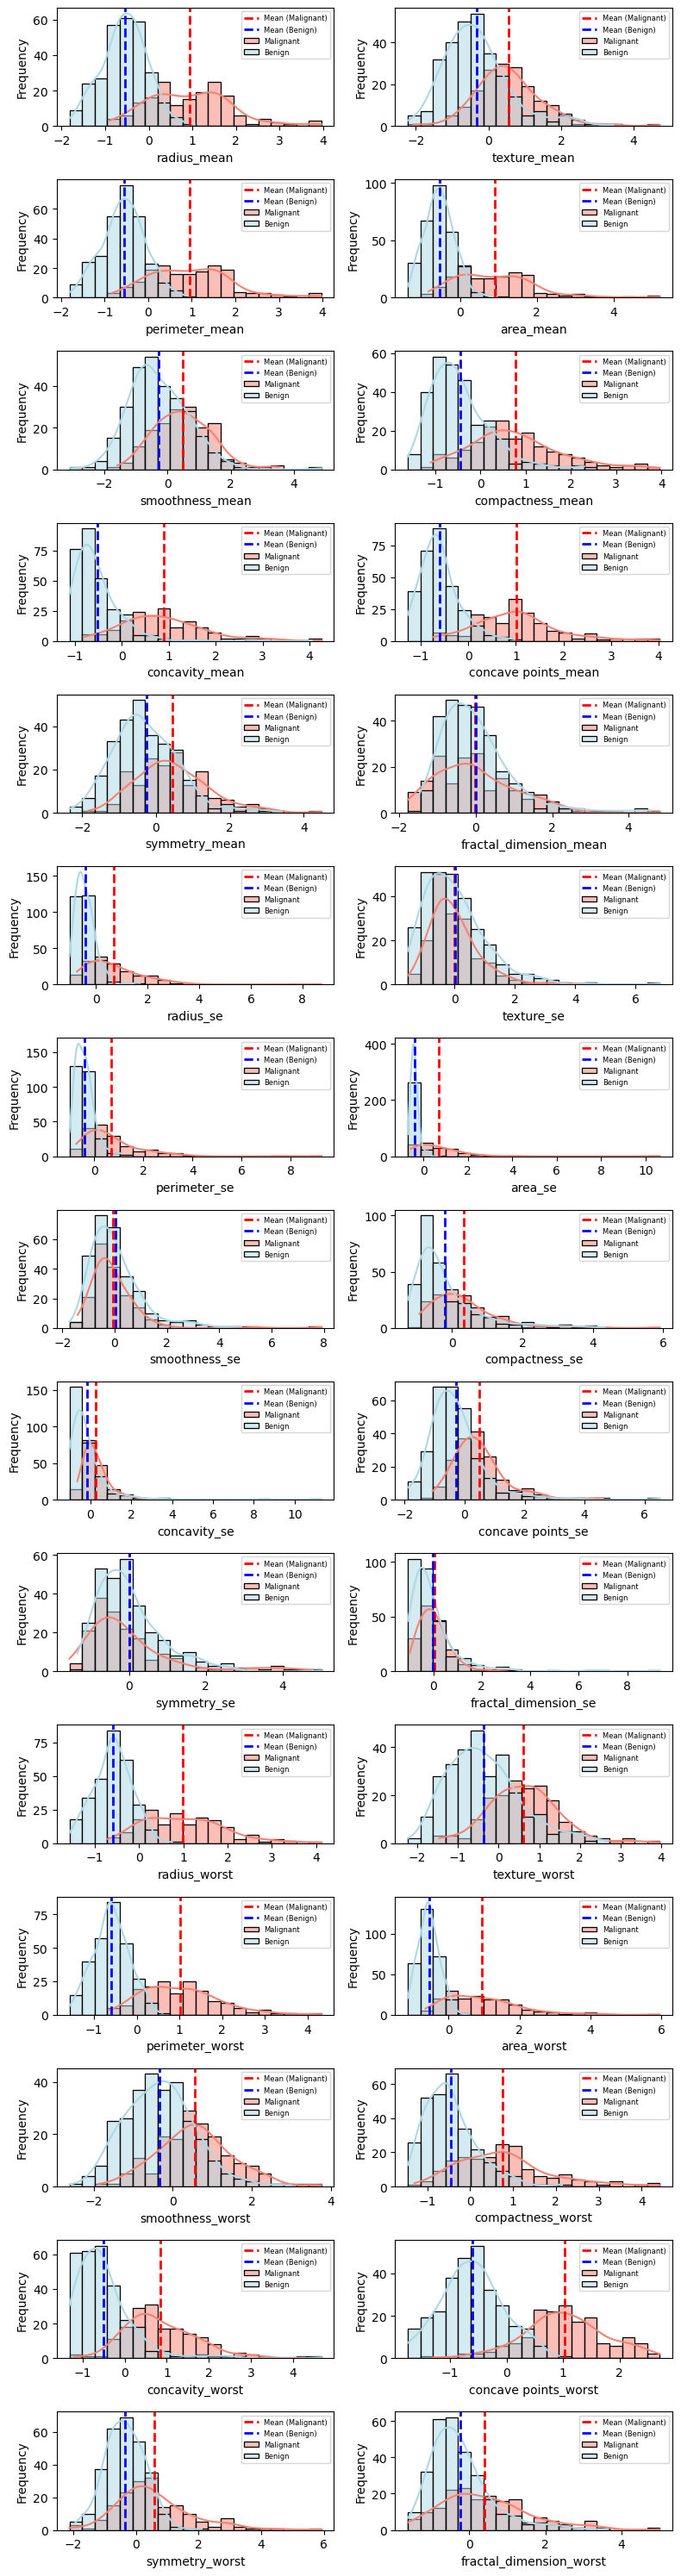

In [19]:
# Enumerate through columns and create a histogram for each

# Create subplots
fig, ax = plt.subplots(ncols=2, nrows=15, figsize=(8,30), dpi=100)
ax = ax.flatten()

# Plot histograms with Gaussian curve for each column (excluding "diagnosis")
for i, col in enumerate(df_scaled.drop(columns="diagnosis").columns):
    # Define data arrays
    malignant_data = df_scaled[df_scaled["diagnosis"] == 1][col]
    benign_data = df_scaled[df_scaled["diagnosis"] == 0][col]
    
    # Calculate common bin edges for the current column
    combined_data = np.concatenate([malignant_data, benign_data])
    bin_edges = np.histogram_bin_edges(combined_data, bins=20)
    
    # Plot histograms
    sns.histplot(malignant_data, color="salmon", label='Malignant', kde=True, ax=ax[i], bins=bin_edges)
    sns.histplot(benign_data, color="lightblue", label='Benign', kde=True, ax=ax[i], bins=bin_edges)
    ax[i].set(xlabel=col, ylabel="Frequency")
    
    # Calculate mean and IQR outliers
    mean_malignant = malignant_data.mean()
    mean_benign = benign_data.mean() 
        
    # Draw vertical lines for mean and IQR outliers
    ax[i].axvline(mean_malignant, color='red', linestyle='dashed', linewidth=2, label='Mean (Malignant)')
    ax[i].axvline(mean_benign, color='blue', linestyle='dashed', linewidth=2, label='Mean (Benign)')
    
    # Legend
    ax[i].legend(fontsize=6)
    
plt.tight_layout()
plt.show()


In [20]:
models = {
    "LinearSVC": LinearSVC(),
    "RandomForest": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression()
}

def evaluate_models(X, y, models):
    scoring_metrics = ["accuracy", "precision", "recall", "f1"]

    results = pd.DataFrame(index=scoring_metrics)

    for model_name, model in models.items():
        model_results = []

        for scoring_metric in scoring_metrics:
            cross_val_score_mean = np.mean(cross_val_score(model, X, y, cv=5, scoring=scoring_metric))
            model_results.append(cross_val_score_mean)

        results[model_name] = model_results

    return results


# for name, model in models:
#     scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
#     mean_score = scores.mean()
#     std_score = scores.std()
#     print(f"{name} - Mean Accuracy: {mean_score:.4f} (Std: {std_score:.4f})")

In [21]:
results_df = evaluate_models(X_train, y_train, models)
print(results_df)

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\

           LinearSVC  RandomForest  LogisticRegression
accuracy    0.826374      0.960440            0.938462
precision   0.992593      0.958173            0.933690
recall      0.776292      0.917112            0.899822
f1          0.865819      0.935497            0.915858


C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

## SMOTE with Scaled X_train

In [23]:
smt = SMOTE()
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

print(f'Distribution BEFORE balancing:\n{y_train.value_counts()}')
print('=-'*16)
print(f'Distribution AFTER balancing:\n{y_train_res.value_counts()}')

#X_train_res
#y_train_res

Distribution BEFORE balancing:
0    286
1    169
Name: diagnosis, dtype: int64
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Distribution AFTER balancing:
0    286
1    286
Name: diagnosis, dtype: int64


In [32]:
# Increased LinearSVC max_iter by +1000

models_v2 = {
    "LinearSVC": LinearSVC(max_iter=10000),
    "RandomForest": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=10000)
}

In [25]:
results_df = evaluate_models(X_train, y_train, models_v2)
print(results_df)

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\

           LinearSVC  RandomForest  LogisticRegression
accuracy    0.927473      0.956044            0.938462
precision   0.830371      0.952579            0.933690
recall      0.798930      0.929055            0.899822
f1          0.806561      0.942763            0.915858


C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

## Correlation Coefficients

Tuning the model by:
Remove IQR outliers
Remove noncorrelative characteristics (p-values of t-test b/w M and B, p-values of correlation coeff)
Resampled using SMOTE
Hyperparameter tuning

In [26]:
# Hyperparameter Tuning

In [27]:
from scipy.stats import pearsonr

In [28]:
X_train_res

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,9.029000,17.330000,58.790000,250.500000,0.106600,0.141300,0.313000,0.043750,0.211100,0.080460,...,10.310000,22.650000,65.500000,324.700000,0.148200,0.436500,1.252000,0.175000,0.422800,0.117500
1,21.090000,26.570000,142.700000,1311.000000,0.114100,0.283200,0.248700,0.149600,0.239500,0.073980,...,26.680000,33.480000,176.500000,2089.000000,0.149100,0.758400,0.678000,0.290300,0.409800,0.128400
2,9.173000,13.860000,59.200000,260.900000,0.077210,0.087510,0.059880,0.021800,0.234100,0.069630,...,10.010000,19.230000,65.590000,310.100000,0.098360,0.167800,0.139700,0.050870,0.328200,0.084900
3,10.650000,25.220000,68.010000,347.000000,0.096570,0.072340,0.023790,0.016150,0.189700,0.063290,...,12.250000,35.190000,77.980000,455.700000,0.149900,0.139800,0.112500,0.061360,0.340900,0.081470
4,10.170000,14.880000,64.550000,311.900000,0.113400,0.080610,0.010840,0.012900,0.274300,0.069600,...,11.020000,17.450000,69.860000,368.600000,0.127500,0.098660,0.021680,0.025790,0.355700,0.080200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,17.794657,11.983559,120.934040,986.946992,0.117482,0.258372,0.278583,0.139024,0.235719,0.076464,...,25.537440,19.404422,183.492086,2047.572506,0.164868,0.620730,0.676563,0.257251,0.445697,0.115509
568,17.501027,21.351695,115.738775,967.132814,0.095620,0.132111,0.115175,0.082088,0.210437,0.056560,...,20.437651,26.534307,137.264649,1300.899685,0.116713,0.273766,0.237175,0.148194,0.305656,0.075981
569,14.210700,23.333900,93.905000,610.148000,0.103510,0.206983,0.171254,0.065696,0.233781,0.071982,...,16.087200,36.457700,109.065999,777.558997,0.154106,0.769392,0.701736,0.177200,0.502898,0.131580
570,22.675094,24.507389,153.307840,1603.786060,0.109543,0.185010,0.305985,0.145156,0.205405,0.060547,...,25.178010,30.473301,174.633194,1976.718407,0.154203,0.390897,0.702580,0.258890,0.307989,0.083659


In [29]:
# DF_TRAIN is SCALED+RES

X_train_res # already a df
y_train_res_df = y_train_res.to_frame(name="diagnosis")
df_train_res = pd.concat([X_train_res, y_train_res_df], axis=1)
df_train_res

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,9.029000,17.330000,58.790000,250.500000,0.106600,0.141300,0.313000,0.043750,0.211100,0.080460,...,22.650000,65.500000,324.700000,0.148200,0.436500,1.252000,0.175000,0.422800,0.117500,0
1,21.090000,26.570000,142.700000,1311.000000,0.114100,0.283200,0.248700,0.149600,0.239500,0.073980,...,33.480000,176.500000,2089.000000,0.149100,0.758400,0.678000,0.290300,0.409800,0.128400,1
2,9.173000,13.860000,59.200000,260.900000,0.077210,0.087510,0.059880,0.021800,0.234100,0.069630,...,19.230000,65.590000,310.100000,0.098360,0.167800,0.139700,0.050870,0.328200,0.084900,0
3,10.650000,25.220000,68.010000,347.000000,0.096570,0.072340,0.023790,0.016150,0.189700,0.063290,...,35.190000,77.980000,455.700000,0.149900,0.139800,0.112500,0.061360,0.340900,0.081470,0
4,10.170000,14.880000,64.550000,311.900000,0.113400,0.080610,0.010840,0.012900,0.274300,0.069600,...,17.450000,69.860000,368.600000,0.127500,0.098660,0.021680,0.025790,0.355700,0.080200,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,17.794657,11.983559,120.934040,986.946992,0.117482,0.258372,0.278583,0.139024,0.235719,0.076464,...,19.404422,183.492086,2047.572506,0.164868,0.620730,0.676563,0.257251,0.445697,0.115509,1
568,17.501027,21.351695,115.738775,967.132814,0.095620,0.132111,0.115175,0.082088,0.210437,0.056560,...,26.534307,137.264649,1300.899685,0.116713,0.273766,0.237175,0.148194,0.305656,0.075981,1
569,14.210700,23.333900,93.905000,610.148000,0.103510,0.206983,0.171254,0.065696,0.233781,0.071982,...,36.457700,109.065999,777.558997,0.154106,0.769392,0.701736,0.177200,0.502898,0.131580,1
570,22.675094,24.507389,153.307840,1603.786060,0.109543,0.185010,0.305985,0.145156,0.205405,0.060547,...,30.473301,174.633194,1976.718407,0.154203,0.390897,0.702580,0.258890,0.307989,0.083659,1


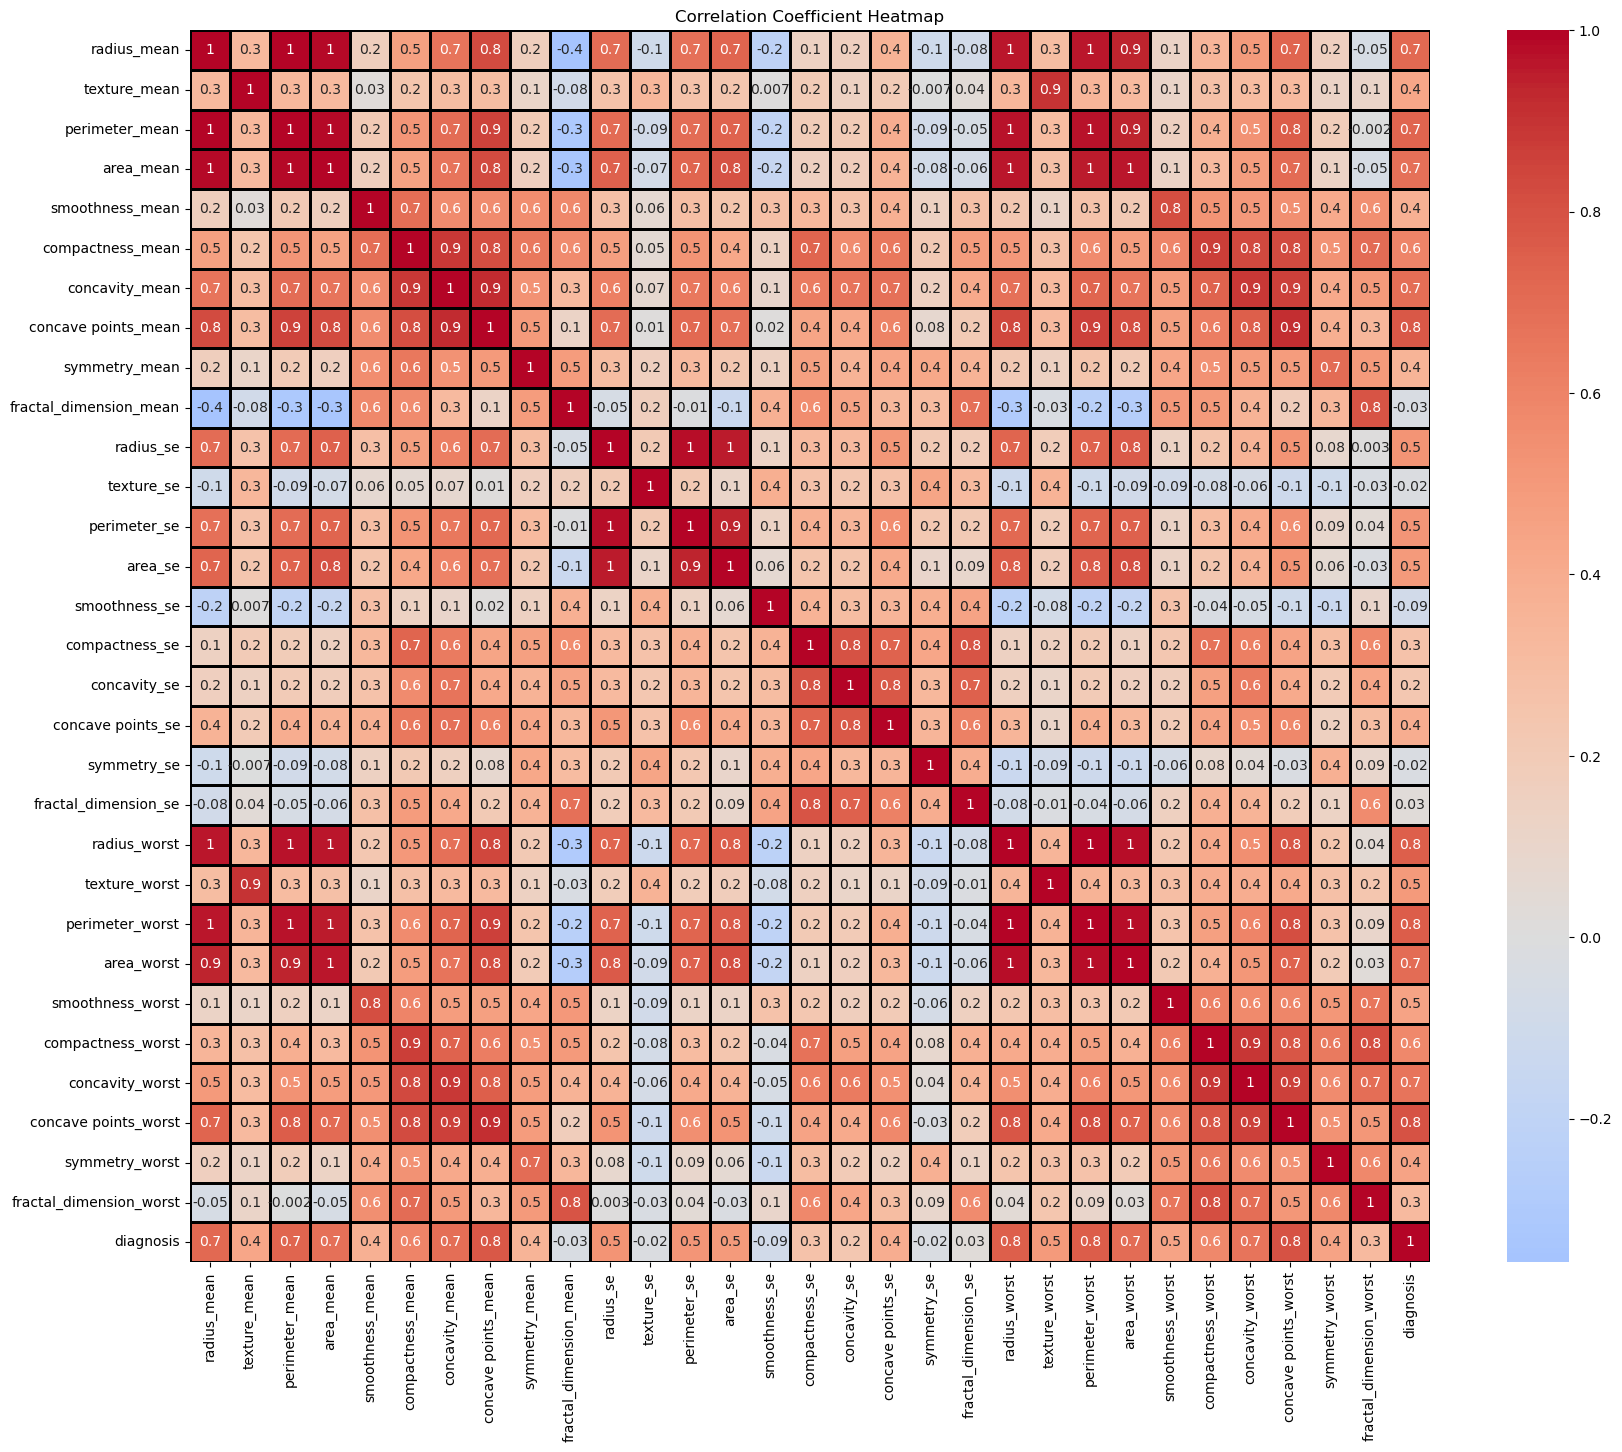

In [30]:
# Create a heatmap using Seaborn
plt.figure(figsize=(20, 16))
sns.heatmap(data = df_train_res.corr(),
            annot = True,
            fmt = '.1g',       #.1g (1 decimal)
            center = 0,        #0.7
            cmap = 'coolwarm',  #rocket
            linewidths = 1,
            linecolor = 'black')
plt.title("Correlation Coefficient Heatmap")
plt.show()

In [33]:
def optimize_corr(dataframe, X_input, y_input, models_input):
    coeff_values = np.arange(0, 1.1, 0.1)
    for coeff in coeff_values:
        columns_to_drop = dataframe.corr()["diagnosis"][dataframe.corr()["diagnosis"] < abs(coeff)].index
        X_train_filtered = X_input.drop(columns=columns_to_drop).values
        y_train_reshaped = y_input.values.ravel()  # Reshape y to a 1D array
        
        results_df = evaluate_models(X_train_filtered, y_train_reshaped, models_input)
        print(f"Coefficient: {coeff}")
        print(results_df)
        print("=" * 40)

# Assuming df_train, X_train_df, y_train_df, evaluate_models, and models are defined elsewhere
optimize_corr(df_train_res, X_train_res, y_train_res_df, models_v2)

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\

Coefficient: 0.0
           LinearSVC  RandomForest  LogisticRegression
accuracy    0.903707      0.968558            0.942273
precision   0.941939      0.969074            0.951478
recall      0.828554      0.965094            0.933575
f1          0.854936      0.966924            0.941774


C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\

Coefficient: 0.1
           LinearSVC  RandomForest  LogisticRegression
accuracy    0.872464      0.973791            0.944027
precision   0.865120      0.968842            0.954684
recall      0.898548      0.979129            0.933575
f1          0.845255      0.970524            0.943391


C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\

Coefficient: 0.2
           LinearSVC  RandomForest  LogisticRegression
accuracy    0.905645      0.966819            0.944027
precision   0.975443      0.965453            0.954684
recall      0.915910      0.975560            0.933575
f1          0.844654      0.970525            0.943391


C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\

Coefficient: 0.30000000000000004
           LinearSVC  RandomForest  LogisticRegression
accuracy    0.858261      0.961587            0.942273
precision   0.841353      0.959244            0.951478
recall      0.884271      0.975560            0.933575
f1          0.912551      0.975499            0.941774


C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\

Coefficient: 0.4
           LinearSVC  RandomForest  LogisticRegression
accuracy    0.919512      0.977285            0.942273
precision   0.940939      0.968776            0.951478
recall      0.891773      0.979068            0.933575
f1          0.895847      0.963446            0.941774


C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\

Coefficient: 0.5
           LinearSVC  RandomForest  LogisticRegression
accuracy    0.891594      0.956293            0.926560
precision   0.885463      0.948257            0.936185
recall      0.828978      0.950998            0.916092
f1          0.835085      0.959673            0.925690


C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\

Coefficient: 0.6000000000000001
           LinearSVC  RandomForest  LogisticRegression
accuracy    0.863707      0.952784            0.924775
precision   0.853564      0.961491            0.932790
recall      0.859710      0.940532            0.916031
f1          0.840356      0.952064            0.923776


C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\

Coefficient: 0.7000000000000001
           LinearSVC  RandomForest  LogisticRegression
accuracy    0.896873      0.942304            0.912540
precision   0.976965      0.951037            0.925530
recall      0.933515      0.940532            0.898488
f1          0.895988      0.944324            0.910793


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_classes.py", line 263, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\utils\validation.py", line 1106, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\utils\validation.py", line 940, in check_array
    raise ValueError(
ValueError: Found array with 0 feature(s) (shape=(457, 0)) while a minimum of 1 is required by LinearSVC.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_classes.py", line 263, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\utils\validation.py", line 1106, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\utils\validation.py", line 940, in check_array
    raise ValueError(
ValueError: Found array with 0 feature(s) (shape=(458, 0)) while a minimum of 1 is required by LinearSVC.


In [45]:
    for model, scores in accuracy_scores.items():
        plt.plot(coeff_values, scores, label=model)
    
    plt.xlabel('Coefficient Filter')
    plt.ylabel('Accuracy Score')
    plt.title('Accuracy Score vs Coefficient Filter')
    plt.legend()
    plt.grid()
    plt.show()

,diagnosis
0,0
1,1
2,0
3,0
4,0
...,...
567,1
568,1
569,1
570,1


In [141]:
def plot_conf_mat(y_test, y_preds):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=True)
    plt.xlabel("Predicted label") # model preds
    plt.ylabel("True label") # true labels 

LinearSVC 
               precision    recall  f1-score   support

           0       0.65      0.86      0.74        72
           1       0.47      0.21      0.30        42

    accuracy                           0.62       114
   macro avg       0.56      0.54      0.52       114
weighted avg       0.59      0.62      0.58       114



C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


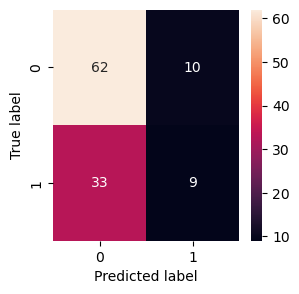

In [142]:
model = LinearSVC()
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
print(f"LinearSVC \n {classification_report(y_test, y_preds)}")
plot_conf_mat(y_test, y_preds)

RandomForestClassifier 
               precision    recall  f1-score   support

           0       0.62      0.82      0.71        72
           1       0.32      0.14      0.20        42

    accuracy                           0.57       114
   macro avg       0.47      0.48      0.45       114
weighted avg       0.51      0.57      0.52       114



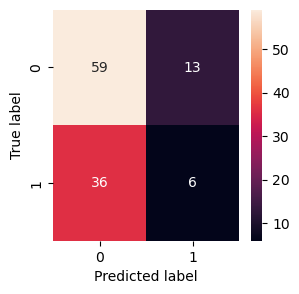

In [143]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
print(f"RandomForestClassifier \n {classification_report(y_test, y_preds)}")
plot_conf_mat(y_test, y_preds)

LogisticRegression 
               precision    recall  f1-score   support

           0       0.67      0.86      0.75        72
           1       0.52      0.26      0.35        42

    accuracy                           0.64       114
   macro avg       0.60      0.56      0.55       114
weighted avg       0.61      0.64      0.60       114



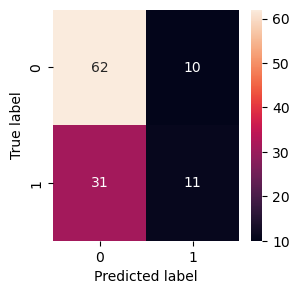

In [144]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
print(f"LogisticRegression \n {classification_report(y_test, y_preds)}")
plot_conf_mat(y_test, y_preds)